In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

/home/gcpuser/sky_workdir/src/art/__init__.py:28: UserWarning: WARNING: Unsloth should be imported before transformers, peft to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  import unsloth  # type: ignore


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
INFO 04-04 19:57:46 __init__.py:207] Automatically detected platform cuda.
==((====))==  Unsloth 2025.3.19: Fast Qwen2 patching. Transformers: 4.49.0. vLLM: 0.7.3.
   \\   /|    NVIDIA H100 80GB HBM3. Num GPUs = 1. Max memory: 79.109 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 9.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading unsloth/qwen2.5-14b-instruct-unsloth-bnb-4bit with actual GPU utilization = 79.39%
Unsloth: Your GPU has CUDA compute capability 9.0 with VRAM = 79.11 GB.
Unsloth: Using conservativeness = 1.0. Chunked prefill tokens = 8192. Num Sequences = 368.
Unsloth: vLLM's KV Cache can use up t

Loading safetensors checkpoint shards:   0% Completed | 0/3 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  33% Completed | 1/3 [00:00<00:01,  1.30it/s]
Loading safetensors checkpoint shards:  67% Completed | 2/3 [00:01<00:00,  1.29it/s]
Loading safetensors checkpoint shards: 100% Completed | 3/3 [00:01<00:00,  1.90it/s]
Loading safetensors checkpoint shards: 100% Completed | 3/3 [00:01<00:00,  1.69it/s]

Loading safetensors checkpoint shards:   0% Completed | 0/3 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  33% Completed | 1/3 [00:00<00:01,  1.23it/s]
Loading safetensors checkpoint shards:  67% Completed | 2/3 [00:01<00:00,  1.21it/s]
Loading safetensors checkpoint shards: 100% Completed | 3/3 [00:01<00:00,  1.82it/s]
Loading safetensors checkpoint shards: 100% Completed | 3/3 [00:01<00:00,  1.61it/s]



INFO 04-04 19:58:09 model_runner.py:1115] Loading model weights took 10.6011 GB
INFO 04-04 19:58:09 punica_selector.py:18] Using PunicaWrapperGPU.
INFO 04-04 19:58:11 worker.py:267] Memory profiling takes 1.67 seconds
INFO 04-04 19:58:11 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.79) = 62.81GiB
INFO 04-04 19:58:11 worker.py:267] model weights take 10.60GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 2.09GiB; the rest of the memory reserved for KV Cache is 49.96GiB.
INFO 04-04 19:58:12 executor_base.py:111] # cuda blocks: 17054, # CPU blocks: 2048
INFO 04-04 19:58:12 executor_base.py:116] Maximum concurrency for 8192 tokens per request: 33.31x
INFO 04-04 19:58:14 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory erro

Capturing CUDA graph shapes: 100%|██████████| 49/49 [00:37<00:00,  1.30it/s]


INFO 04-04 19:58:51 model_runner.py:1562] Graph capturing finished in 38 secs, took 9.48 GiB
INFO 04-04 19:58:51 llm_engine.py:436] init engine (profile, create kv cache, warmup model) took 41.92 seconds


Unsloth 2025.3.19 patched 48 layers with 48 QKV layers, 48 O layers and 48 MLP layers.


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/800 [00:00<?, ?it/s]

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: bradhilton to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

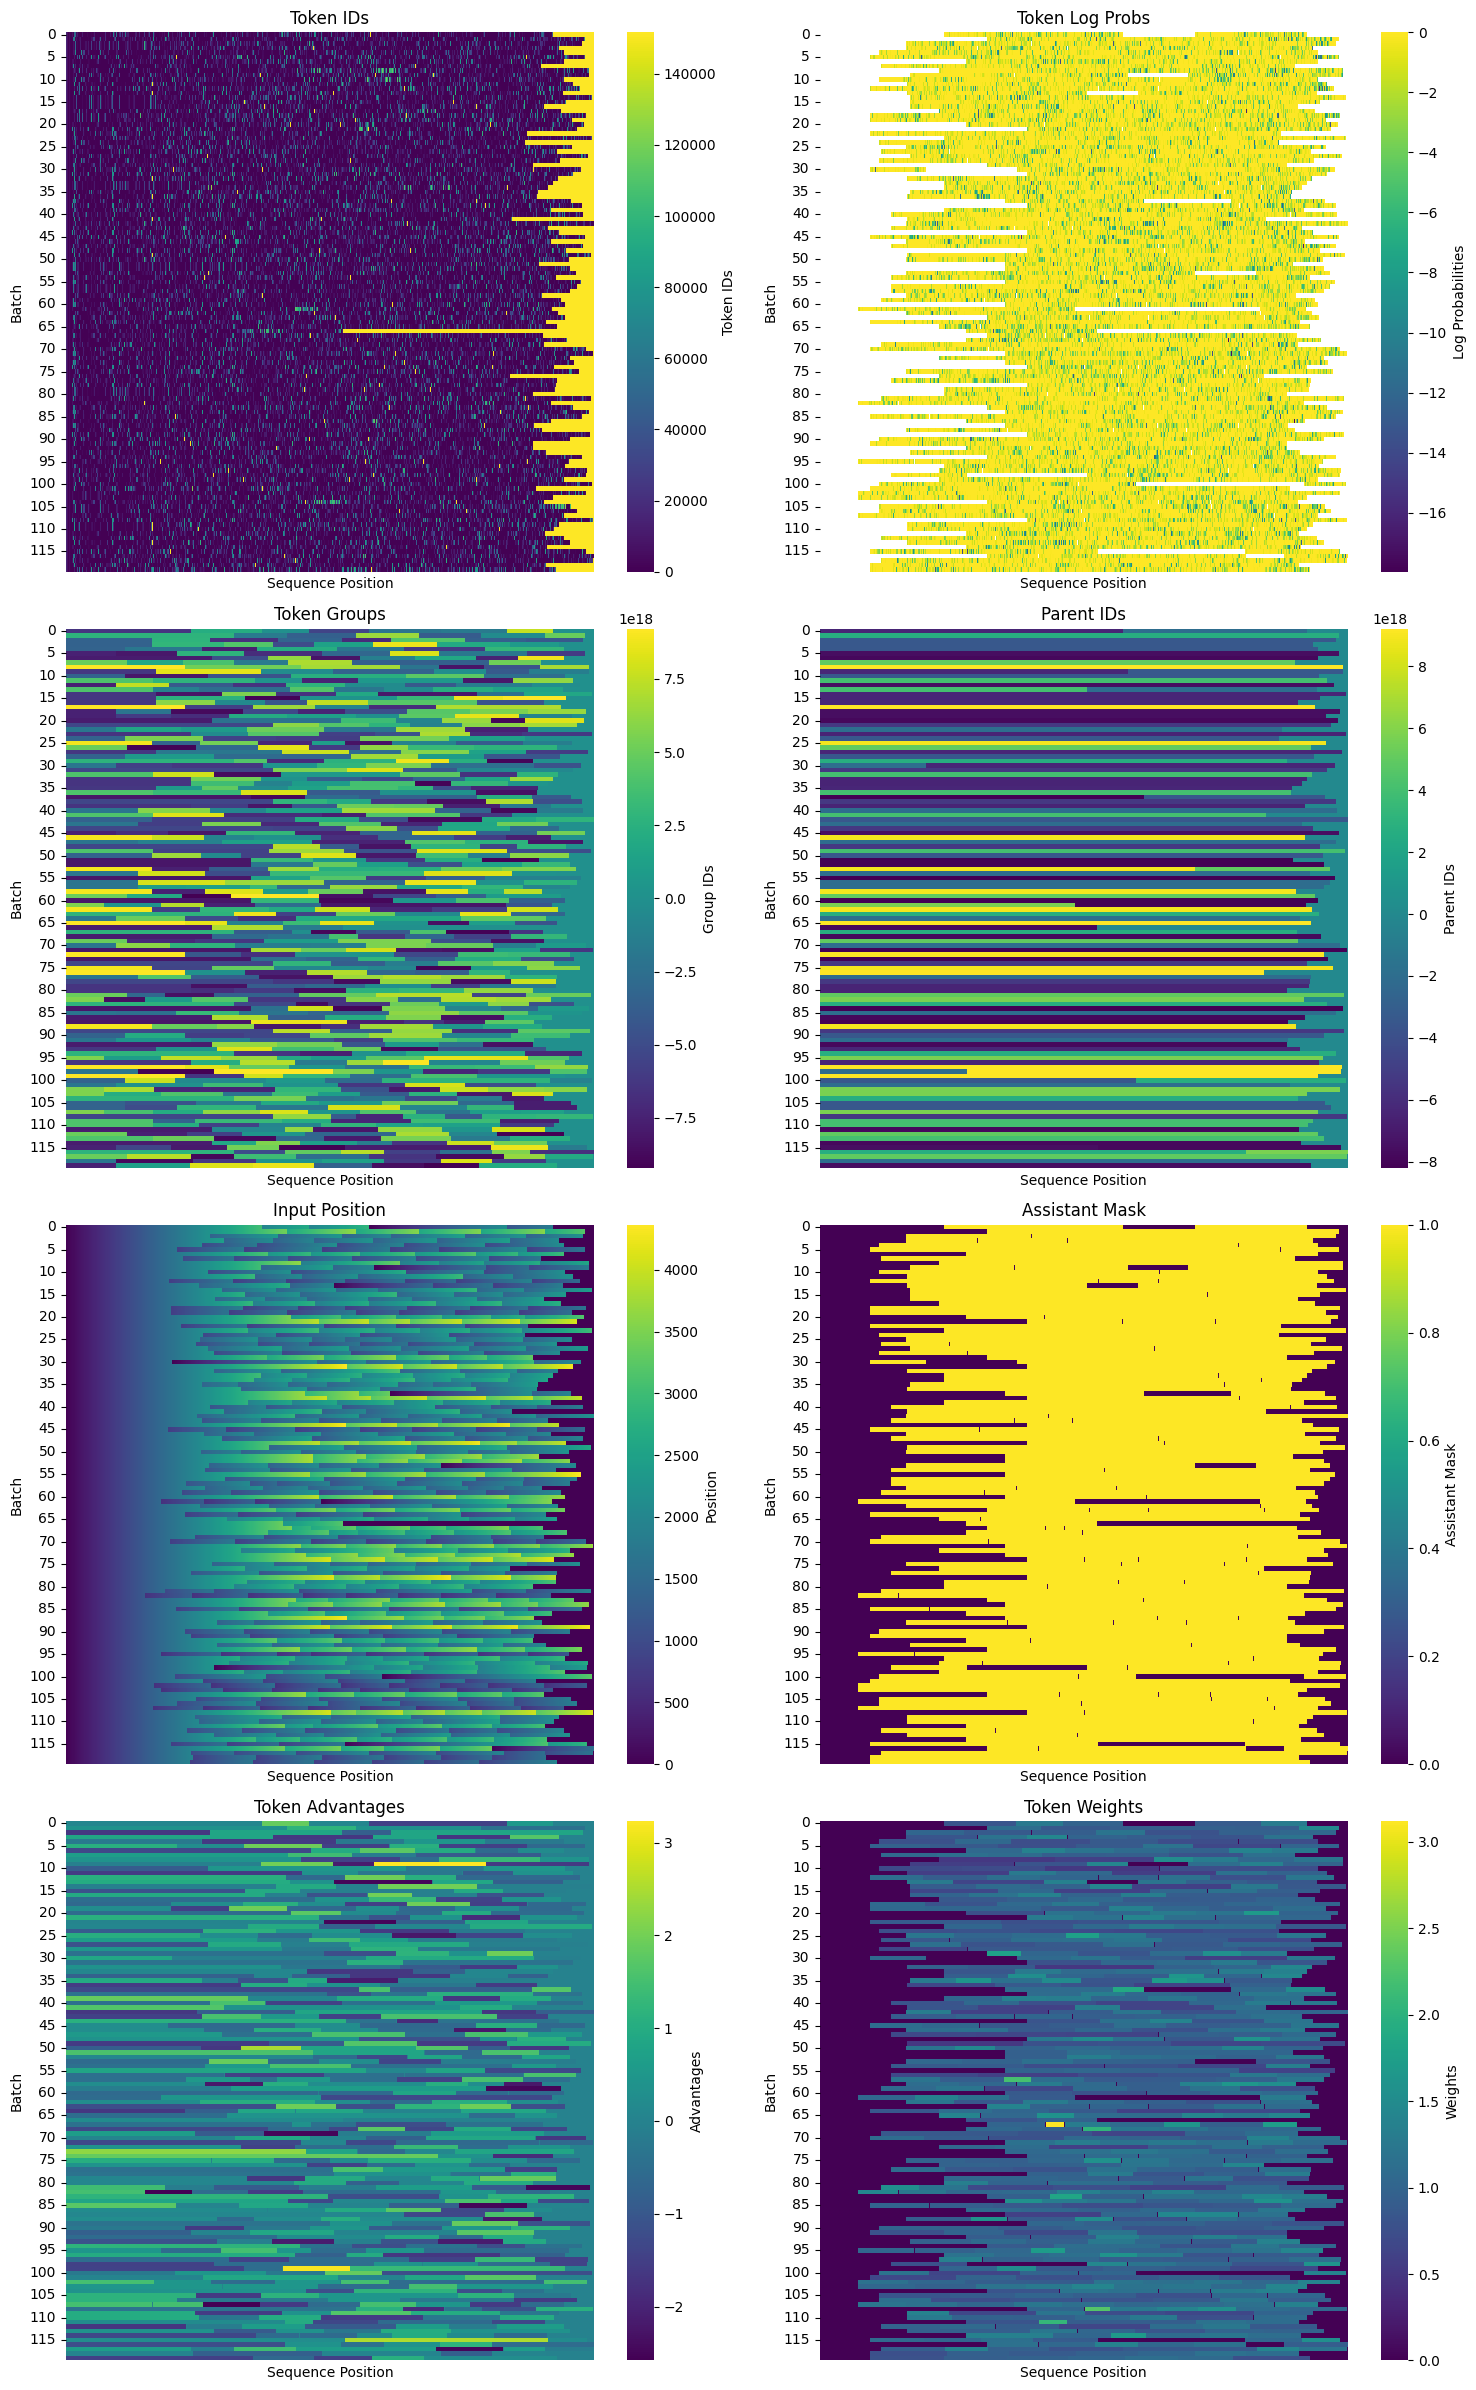

tune:   0%|          | 0/120 [00:00<?, ?it/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 100,000 | Num Epochs = 3 | Total steps = 300,000
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 1 x 1) = 2
 "-____-"     Trainable parameters = 34,406,400/14,000,000,000 (0.25% trained)


Unsloth: Will smartly offload gradients to save VRAM!


In [ ]:
import art
import asyncio
from dotenv import load_dotenv
import json
import openai
import random
import re
from typing import TypedDict

load_dotenv()


class TemporalCluePuzzle(TypedDict):
    num_clues: int
    prompt: str
    solution: dict[str, str]


puzzles: list[TemporalCluePuzzle] = json.load(open("./data/temporal-clue/puzzles.json"))
val_puzzles = puzzles[:64]
test_puzzles = puzzles[64:128]
train_puzzles = puzzles[128:]
random.seed(42)
random.shuffle(train_puzzles)


api = art.UnslothAPI(wandb_project="agent-reinforcement-training")
model = await api._get_or_create_model(
    name="temporal-clue-unsloth-002",
    base_model="Qwen/Qwen2.5-14B-Instruct",
    _config={
        "init_args": {
            "gpu_memory_utilization": 0.8,
            "enable_sleep_mode": True,
        }
    },
)


async def rollout(
    client: openai.AsyncOpenAI, puzzle: TemporalCluePuzzle
) -> art.Trajectory:
    messages: art.Messages = [{"role": "user", "content": puzzle["prompt"]}]
    chat_completion = await client.chat.completions.create(
        messages=messages, model=model.name
    )
    choice = chat_completion.choices[0]
    content = choice.message.content
    assert isinstance(content, str)
    num_correct = 0
    for key, value in puzzle["solution"].items():
        if matches := re.findall(rf"{key}\. ([A-Za-z \.:-]+)", content):
            match = matches[-1]
            if match.strip().lower() == value.lower():
                num_correct += 1
    reward = acc = num_correct / len(puzzle["solution"])
    return art.Trajectory(
        messages_and_choices=[*messages, choice], reward=reward, metrics={"acc": acc}
    )


stride = 16
openai_client = await model.openai_client()
for i in range(await model.get_iteration(), 1_000):
    val_groups, train_groups = await asyncio.gather(
        art.gather_trajectories(
            (
                (rollout(openai_client, puzzle) for _ in range(2))
                for puzzle in val_puzzles
            ),
            pbar_desc="val",
            stream_chat_completions=8,
            return_exceptions=False,
        ),
        art.gather_trajectories(
            (
                (rollout(openai_client, puzzle) for _ in range(50))
                for puzzle in train_puzzles[i * stride : (i + 1) * stride]
            ),
            pbar_desc="train",
            return_exceptions=False,
        ),
    )
    await model.log(val_groups)
    await model.clear_iterations()
    await model.tune(
        train_groups,
        config=art.TuneConfig(
            lr=5e-5, sequence_length=8192, plot_tensors=True, verbosity=2
        ),
    )